<a href="https://colab.research.google.com/github/sierra-hunt/github-and-kaggle-ML-work/blob/main/DL_Semantic_Segmentation_on_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segamtic Segmentation on Cultural Heritage Artwork Images for Damage Detection

My 2024 deep learning project focused on creating a model for damage detection in historical images. The core challenge was to build a system that could identify and categorize different types of deterioration—such as peeling paint, stains, and folds—in digitized artifacts like parchment and paintings.

I approached this as a semantic segmentation task, where the goal was to predict a damage label for every pixel in an image.

After experimenting with different architectures, I implemented a model based on ResNet50, modified into a Fully Convolutional Network. I chose to fine-tune a pre-trained model to leverage transfer learning, which was crucial for generalizing to materials not seen during training. Key technical decisions included using cross-entropy loss for multi-class segmentation, the Adam optimizer, and implementing upsampling to restore the original image resolution in the output mask.

The project involved the full pipeline: data exploration, model design, training, hyperparameter tuning, and a thorough evaluation of results on a held-out test set, with a particular focus on the model's generalization capability.

## Housekeeping

In [ ]:
!pip install gdown pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import os
import pandas as pd
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 243748701
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gdown
import shutil

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Load dataset

We then load the metadata in a dataframe for convenience

In [ ]:
!pwd

/content


In [ ]:
!gdown 1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS -O damages.zip

Downloading...
From (original): https://drive.google.com/uc?id=1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS
From (redirected): https://drive.google.com/uc?id=1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS&confirm=t&uuid=67139e60-9deb-44f0-b3a8-3d67d8eb0666
To: /content/damages.zip
100% 3.32G/3.32G [00:27<00:00, 119MB/s]


In [ ]:
# set  that to wherever you want to store the data (eg, your Google Drive), choose a persistent location!
root_dir = '.'
data_dir = os.path.join(root_dir, "damage_data")
csv_path = os.path.join(data_dir, 'metadata.csv')

try:
    df = pd.read_csv(csv_path)

except:  # if the dataset has not been downloaded yet, do it.
    zip_path = os.path.join(root_dir, 'damages.zip')
    gdown.download(id='1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS', output=zip_path)
    shutil.unpack_archive(zip_path, root_dir)
    df = pd.read_csv(csv_path)

Downloading...
From (original): https://drive.google.com/uc?id=1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS
From (redirected): https://drive.google.com/uc?id=1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS&confirm=t&uuid=873bb35e-fc58-49db-8d00-3a3601bb3863
To: /content/damages.zip
100%|██████████| 3.32G/3.32G [00:31<00:00, 106MB/s]


This dataframe has the paths of where the dataset images and annotation labels are stored, plus classification labels.

In [ ]:
df

id   material             content  \
0    cljmrkz5n341f07clcujw105j  Parchment  Artistic depiction   
1    cljmrkz5n341n07clf1u410ed  Parchment  Artistic depiction   
2    cljmrkz5n341r07clhl93dpre  Parchment  Artistic depiction   
3    cljmrkz5n341v07cl2gfhd6zj  Parchment  Artistic depiction   
4    cljmrkz5n341z07cldbn01un3  Parchment  Artistic depiction   
..                         ...        ...                 ...   
390  clnofow7i00n2076ubpfodf4d       Wood  Artistic depiction   
391  clnrm7fvu092q07840tq9zs03       Wood  Artistic depiction   
392  clnrm7fvu092r0784a6p2m5li       Wood  Artistic depiction   
393  clnrm7fvu092s0784tgwccewe       Wood  Artistic depiction   
394  clnrm7fvu092t0784ltljhiu0       Wood  Artistic depiction   

                                            image_path  \
0    ./damage_data/image_path/cljmrkz5n341f07clcujw...   
1    ./damage_data/image_path/cljmrkz5n341n07clf1u4...   
2    ./damage_data/image_path/cljmrkz5n341r07clhl93...   
3    ./damage_data/image_path/cljmrkz5n341v07cl2gfh...   
4    ./damage_data/image_path/cljmrkz5n341z07cldbn0...   
..                                                 ...   
390  ./damage_data/image_path/clnofow7i00n2076ubpfo...   
391  ./damage_data/image_path/clnrm7fvu092q07840tq9...   
392  ./damage_data/image_path/clnrm7fvu092r0784a6p2...   
393  ./damage_data/image_path/clnrm7fvu092s0784tgwc...   
394  ./damage_data/image_path/clnrm7fvu092t0784ltlj...   

                                       annotation_path  \
0    ./damage_data/annotation_path/cljmrkz5n341f07c...   
1    ./damage_data/annotation_path/cljmrkz5n341n07c...   
2    ./damage_data/annotation_path/cljmrkz5n341r07c...   
3    ./damage_data/annotation_path/cljmrkz5n341v07c...   
4    ./damage_data/annotation_path/cljmrkz5n341z07c...   
..                                                 ...   
390  ./damage_data/annotation_path/clnofow7i00n2076...   
391  ./damage_data/annotation_path/clnrm7fvu092q078...   
392  ./damage_data/annotation_path/clnrm7fvu092r078...   
393  ./damage_data/annotation_path/clnrm7fvu092s078...   
394  ./damage_data/annotation_path/clnrm7fvu092t078...   

                                   annotation_rgb_path  
0    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
1    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
2    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
3    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
4    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
..                                                 ...  
390  ./damage_data/annotation_rgb_path/clnofow7i00n...  
391  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
392  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
393  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
394  ./damage_data/annotation_rgb_path/clnrm7fvu092...  

[395 rows x 6 columns]

The images in the dataset are categorised in terms of the type of `material`, meaning what was the original picture on, eg, Parchment, Glass or Textile.

In [ ]:
df['material'].unique()

array(['Parchment', 'Film emulsion', 'Glass', 'Paper', 'Tesserae',
       'Canvas', 'Textile', 'Ceramic', 'Wood'], dtype=object)

Moreover, images are also categorised in terms on the `content` of the image, meaning what is depicted: eg, Line art, geometric patterns, etc.

In [ ]:
df['content'].unique()

array(['Artistic depiction', 'Line art', 'Photographic depiction',
       'Geometric patterns'], dtype=object)

## Labels
Segmentation labels are saved as a PNG image, where each number from 1 to 15 corresponds to a damage class like Peel, Scratch etc; the Background class is set to 255, and the Clean class (no damage) is set to 0. We also provide code to convert these annotation values to RGB colours for nicer visualisation, but for training you should use the original annotations.

In [ ]:
name_color_mapping = {
    "Material loss": "#1CE6FF",
    "Peel": "#FF34FF",
    "Dust": "#FF4A46",
    "Scratch": "#008941",
    "Hair": "#006FA6",
    "Dirt": "#A30059",
    "Fold": "#FFA500",
    "Writing": "#7A4900",
    "Cracks": "#0000A6",
    "Staining": "#63FFAC",
    "Stamp": "#004D43",
    "Sticker": "#8FB0FF",
    "Puncture": "#997D87",
    "Background": "#5A0007",
    "Burn marks": "#809693",
    "Lightleak": "#f6ff1b",
}

class_names = [ 'Material loss', 'Peel', 'Dust', 'Scratch',
                'Hair', 'Dirt', 'Fold', 'Writing', 'Cracks', 'Staining', 'Stamp',
                'Sticker', 'Puncture', 'Burn marks', 'Lightleak', 'Background']

class_to_id = {class_name: idx+1 for idx, class_name in enumerate(class_names)}
class_to_id['Background'] = 255  # Set the Background ID to 255

def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

id_to_rgb = {class_to_id[class_name]: hex_to_rgb(color) for class_name, color in name_color_mapping.items()}
id_to_rgb[0] = (0,0,0)

# Create id2label mapping: ID to class name
id2label = {idx: class_name for class_name, idx in class_to_id.items()}

# Create label2id mapping: class name to ID, which is the same as class_to_id
label2id = class_to_id

# Non-damaged pixels
id2label[0] = 'Clean'
label2id['Clean'] = 0

In [ ]:
from IPython.display import Markdown

legend='#### Colour labels for each damage type\n'
for damage in class_names:
    legend += '- <span style="color: {color}">{damage}</span>.\n'.format(color=name_color_mapping[damage], damage=damage)
display(Markdown(legend))

#### Colour labels for each damage type
- <span style="color: #1CE6FF">Material loss</span>.
- <span style="color: #FF34FF">Peel</span>.
- <span style="color: #FF4A46">Dust</span>.
- <span style="color: #008941">Scratch</span>.
- <span style="color: #006FA6">Hair</span>.
- <span style="color: #A30059">Dirt</span>.
- <span style="color: #FFA500">Fold</span>.
- <span style="color: #7A4900">Writing</span>.
- <span style="color: #0000A6">Cracks</span>.
- <span style="color: #63FFAC">Staining</span>.
- <span style="color: #004D43">Stamp</span>.
- <span style="color: #8FB0FF">Sticker</span>.
- <span style="color: #997D87">Puncture</span>.
- <span style="color: #809693">Burn marks</span>.
- <span style="color: #f6ff1b">Lightleak</span>.
- <span style="color: #5A0007">Background</span>.


## Create dataset splits

Here is an example of how to split the dataset for Leave-one-out cross validation (LOOCV) based on material.

In [ ]:
def create_leave_one_out_splits(df, criterion='material'):

    grouped = df.groupby(criterion)
    content_splits = {name: group for name, group in grouped}
    unique_val = df[criterion].unique()

    # Initialize a dictionary to hold the train and validation sets for each LOOCV iteration
    loocv_splits = {}

    for value in unique_val:
        # Create the validation set
        val_set = content_splits[value]

        # Create the training set
        train_set = pd.concat([content_splits[c] for c in unique_val if c != value])

        # Add these to the loocv_splits dictionary
        loocv_splits[value] = {'train_set': train_set, 'val_set': val_set}

    return loocv_splits


For this coursework, we will want to assess the generalisation of the method, so for that we will keep one type of material (`Canvas`) as test set, and only train on the remaining ones.

In [ ]:
# split the dataset according to material type
full_splits = create_leave_one_out_splits(df, 'material')

# use Canvas as test set
test_set = full_splits['Canvas']['val_set']

# use the rest as training set
train_set = full_splits['Canvas']['train_set']

# prepare a leave-one-out cross validation for the training set
loocv_splits = create_leave_one_out_splits(train_set, 'material')

# identify the different type of image content
unique_material = train_set['material'].unique()
print(unique_material)


['Parchment' 'Film emulsion' 'Glass' 'Paper' 'Tesserae' 'Textile'
 'Ceramic' 'Wood']


To help you, here are some helper functions to help crop and process images.

In [ ]:
def random_square_crop_params(image, target_size):
    width, height = image.size
    min_edge = min(width, height)

    # Conditionally set the range for random crop size
    lower_bound = min(min_edge, target_size)
    upper_bound = max(min_edge, target_size)

    # Generate crop_size
    crop_size = random.randint(lower_bound, upper_bound)

    # Check and adjust if crop_size is larger than any dimension of the image
    if crop_size > width or crop_size > height:
        crop_size = min(width, height)

    # Generate random coordinates for the top-left corner of the crop
    x = random.randint(0, width - crop_size)
    y = random.randint(0, height - crop_size)

    return (x, y, x + crop_size, y + crop_size)

def apply_crop_and_resize(image, coords, target_size):
    image_crop = image.crop(coords)
    image_crop = image_crop.resize((target_size, target_size), Image.NEAREST)
    return image_crop

We also provide a simple class for holding the dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
import numpy as np
from PIL import Image

from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size, is_train=True):
        self.dataframe = dataframe
        self.target_size = target_size
        self.is_train = is_train

        self.to_tensor = transforms.ToTensor()

        # Define the normalization transform
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
            return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        annotation = Image.open(row['annotation_path']).convert('L')
        annotation_rgb = Image.open(row['annotation_rgb_path']).convert('RGB')
        id = row['id']
        material = row['material']
        content = row['content']

        if self.is_train:
            # Generate random square cropping coordinates
            crop_coords = random_square_crop_params(image, self.target_size)

            # Apply the same cropping and resizing to all
            image = apply_crop_and_resize(image, crop_coords, self.target_size)
            annotation = apply_crop_and_resize(annotation, crop_coords, self.target_size)
            annotation_rgb = apply_crop_and_resize(annotation_rgb, crop_coords, self.target_size)
        else:  # Validation
            # Instead of cropping, downsize the images so that the longest edge is 1024 or less
            max_edge = max(image.size)
            if max_edge > 1024:
                downsample_ratio = 1024 / max_edge
                new_size = tuple([int(dim * downsample_ratio) for dim in image.size])

                image = image.resize(new_size, Image.BILINEAR)
                annotation = annotation.resize(new_size, Image.NEAREST)
                annotation_rgb = annotation_rgb.resize(new_size, Image.BILINEAR)

        # Convert PIL images to PyTorch tensors
        image = self.to_tensor(image)
        annotation = torch.tensor(np.array(annotation), dtype=torch.long)
        annotation_rgb = self.to_tensor(annotation_rgb)
        #annotation_resized = F.interpolate(annotation[None, None].float(), size=(88, 128), mode='nearest')[0].long()

        # Normalize the image
        image = self.normalize(image)

        # Change all values in annotation that are 255 to 16
        annotation[annotation == 255] = 16

        return {
            'image': image,
            'annotation': annotation,
            'annotation_rgb': annotation_rgb,
            'id': id,
            'material': material,
            'content': content
        }

Here we create a DataModule which encapsulates our training and validation DataLoaders; you can also do this manually by only using the Pytorch DataLoader class, lines 24 and 27.

In [ ]:
from torch.utils.data import DataLoader

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, loocv_splits, current_material, target_size, batch_size=32, num_workers=4):
        super().__init__()
        self.loocv_splits = loocv_splits
        self.current_material = current_material
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # Load current train and validation set based on LOOCV iteration
        train_df = self.loocv_splits[self.current_material]['train_set']
        val_df = self.loocv_splits[self.current_material]['val_set'].sample(frac=1).reset_index(drop=True)

        self.train_dataset = CustomDataset(dataframe=train_df, target_size=self.target_size, is_train=True)
        self.val_dataset = CustomDataset(dataframe=val_df, target_size=self.target_size, is_train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        pass


The following will create a data module for validating on the first content in the list (`Parchment`) and training on all the other types of material (you will want to do that for each fold).

In [ ]:
data_module = CustomDataModule(loocv_splits=loocv_splits,
                               current_material=unique_material[0],
                               target_size=512,
                               batch_size=4)

Finally, we can get the train and validation data loaders from the data module.

In [ ]:
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Dataset visualisation

We need to denormalise the images so we can display them

In [ ]:
# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_cpy = image.copy()
    for i in range(3):
        img_cpy[..., i] = img_cpy[..., i] * std[i] + mean[i]
    return img_cpy

## Visualise training samples
Random square crops of the images and correspoding RGB annotations on their own and overlaid onto the image.

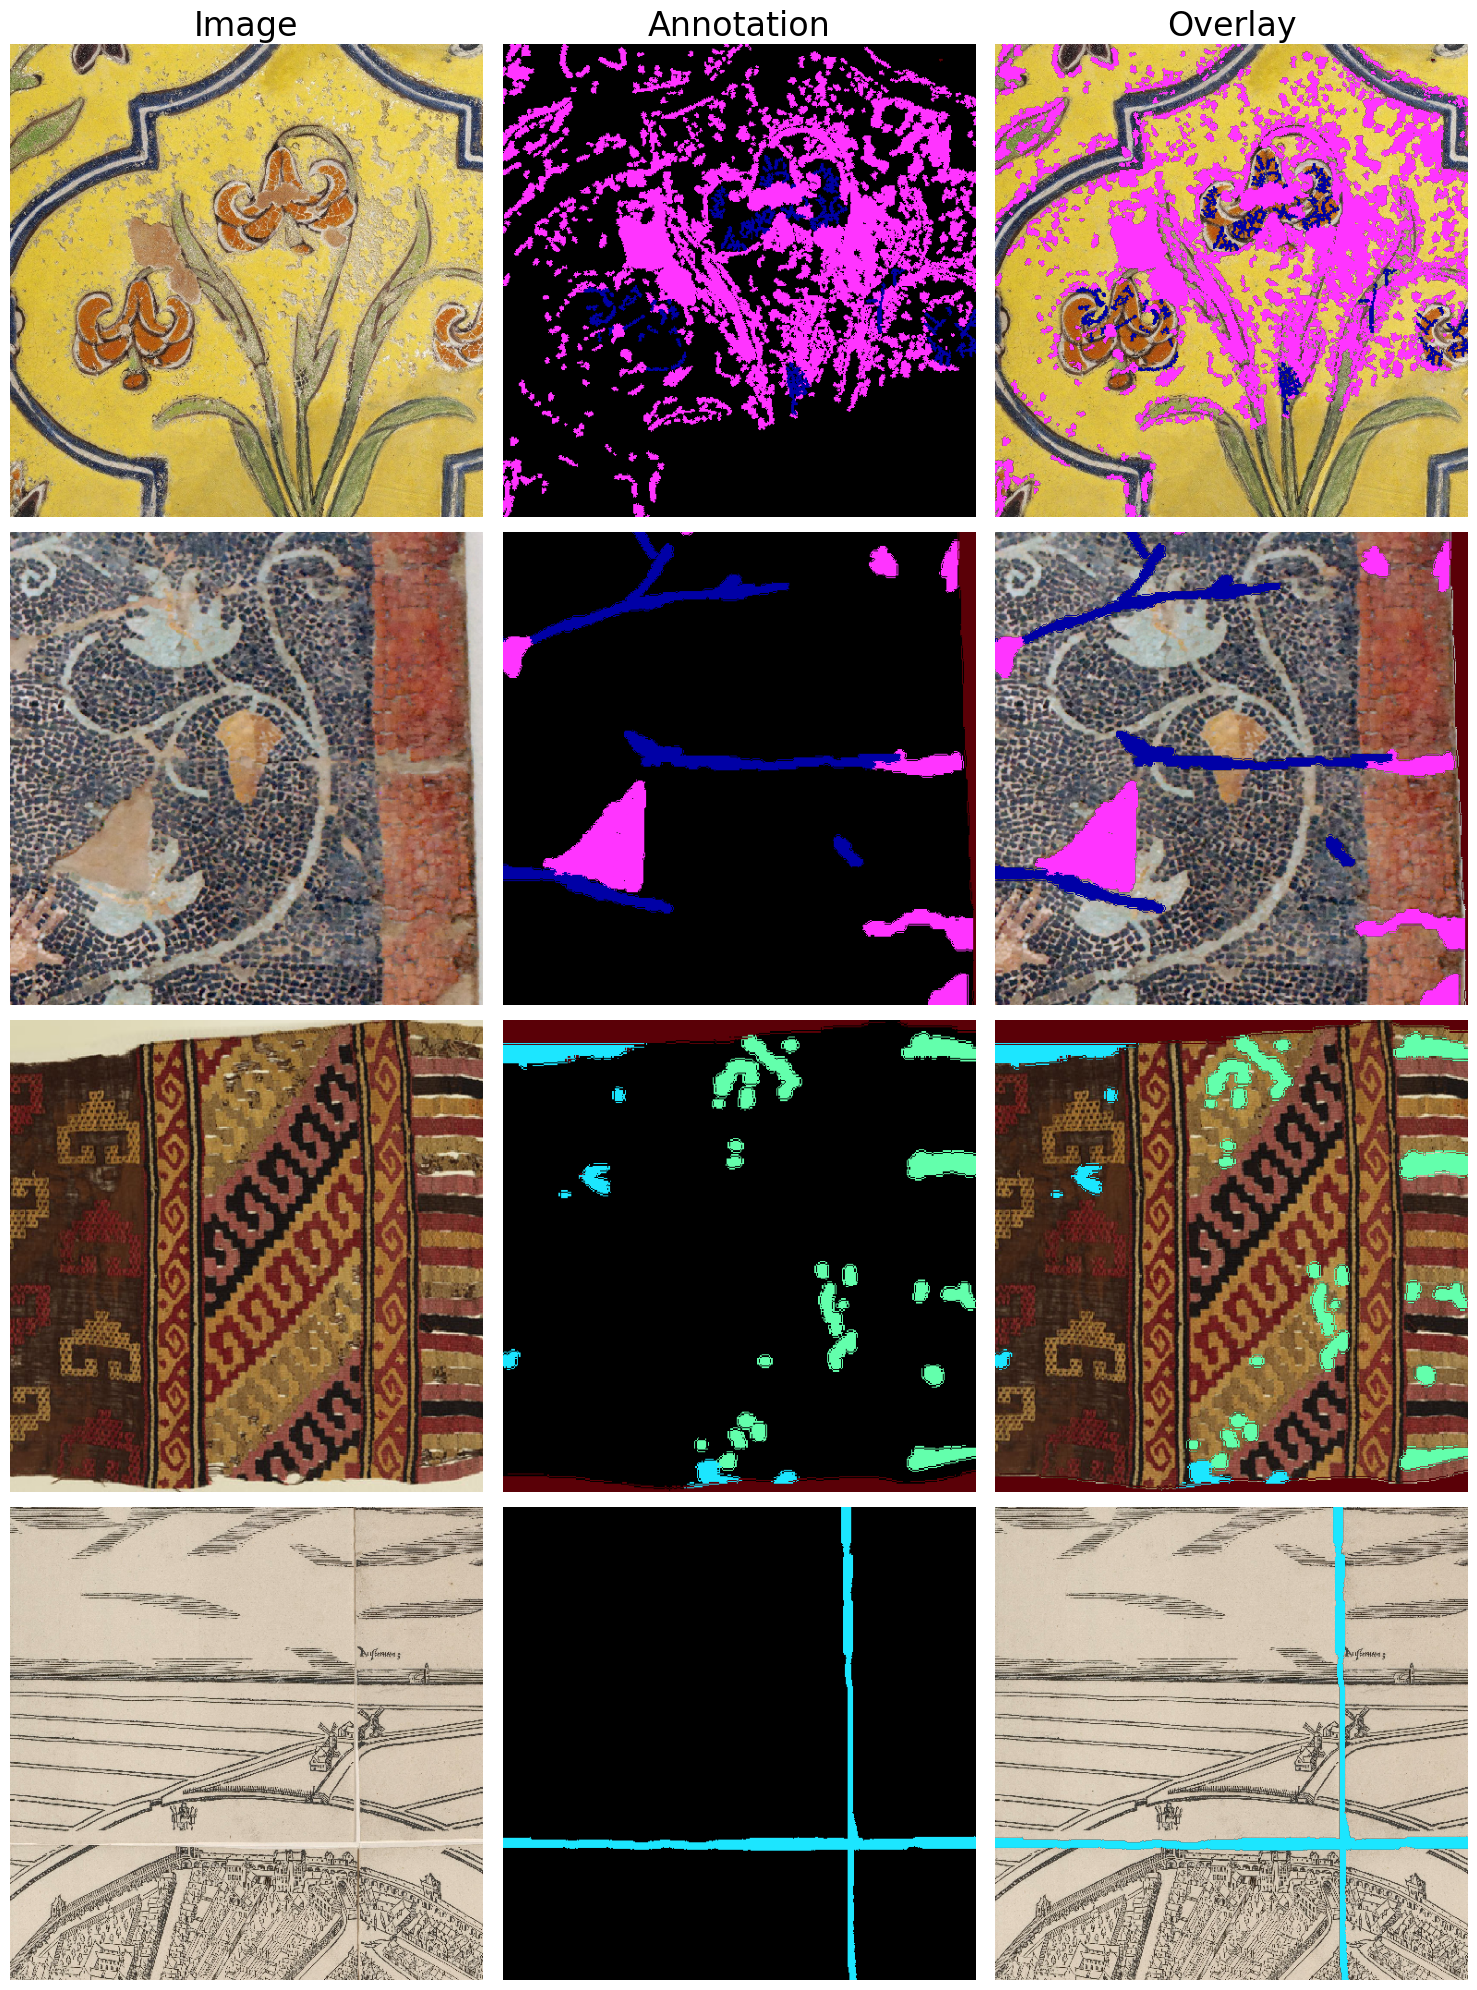

In [ ]:
example_batch = next(iter(train_loader))

example_images = example_batch['image']
example_annotations = example_batch['annotation']
example_annotation_rgbs = example_batch['annotation_rgb']

# Number of examples to visualize
N = min(4, len(example_images))

fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
    ax.set_title(col, fontsize=24)

for i in range(N):
    example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
    example_annotation = Image.fromarray(np.uint8(example_annotations[i].numpy()), 'L')
    example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C

    # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
    alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
    example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))

    axes[i, 0].imshow(example_image)
    axes[i, 0].axis('off')

    #axes[i, 1].imshow(example_annotation, cmap='gray', vmin=0, vmax=255)
    axes[i, 1].imshow(example_annotation_rgb)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(example_image)
    axes[i, 2].imshow(example_annotation_rgba)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Visualising the validation set, which loads the left-out class as whole images.

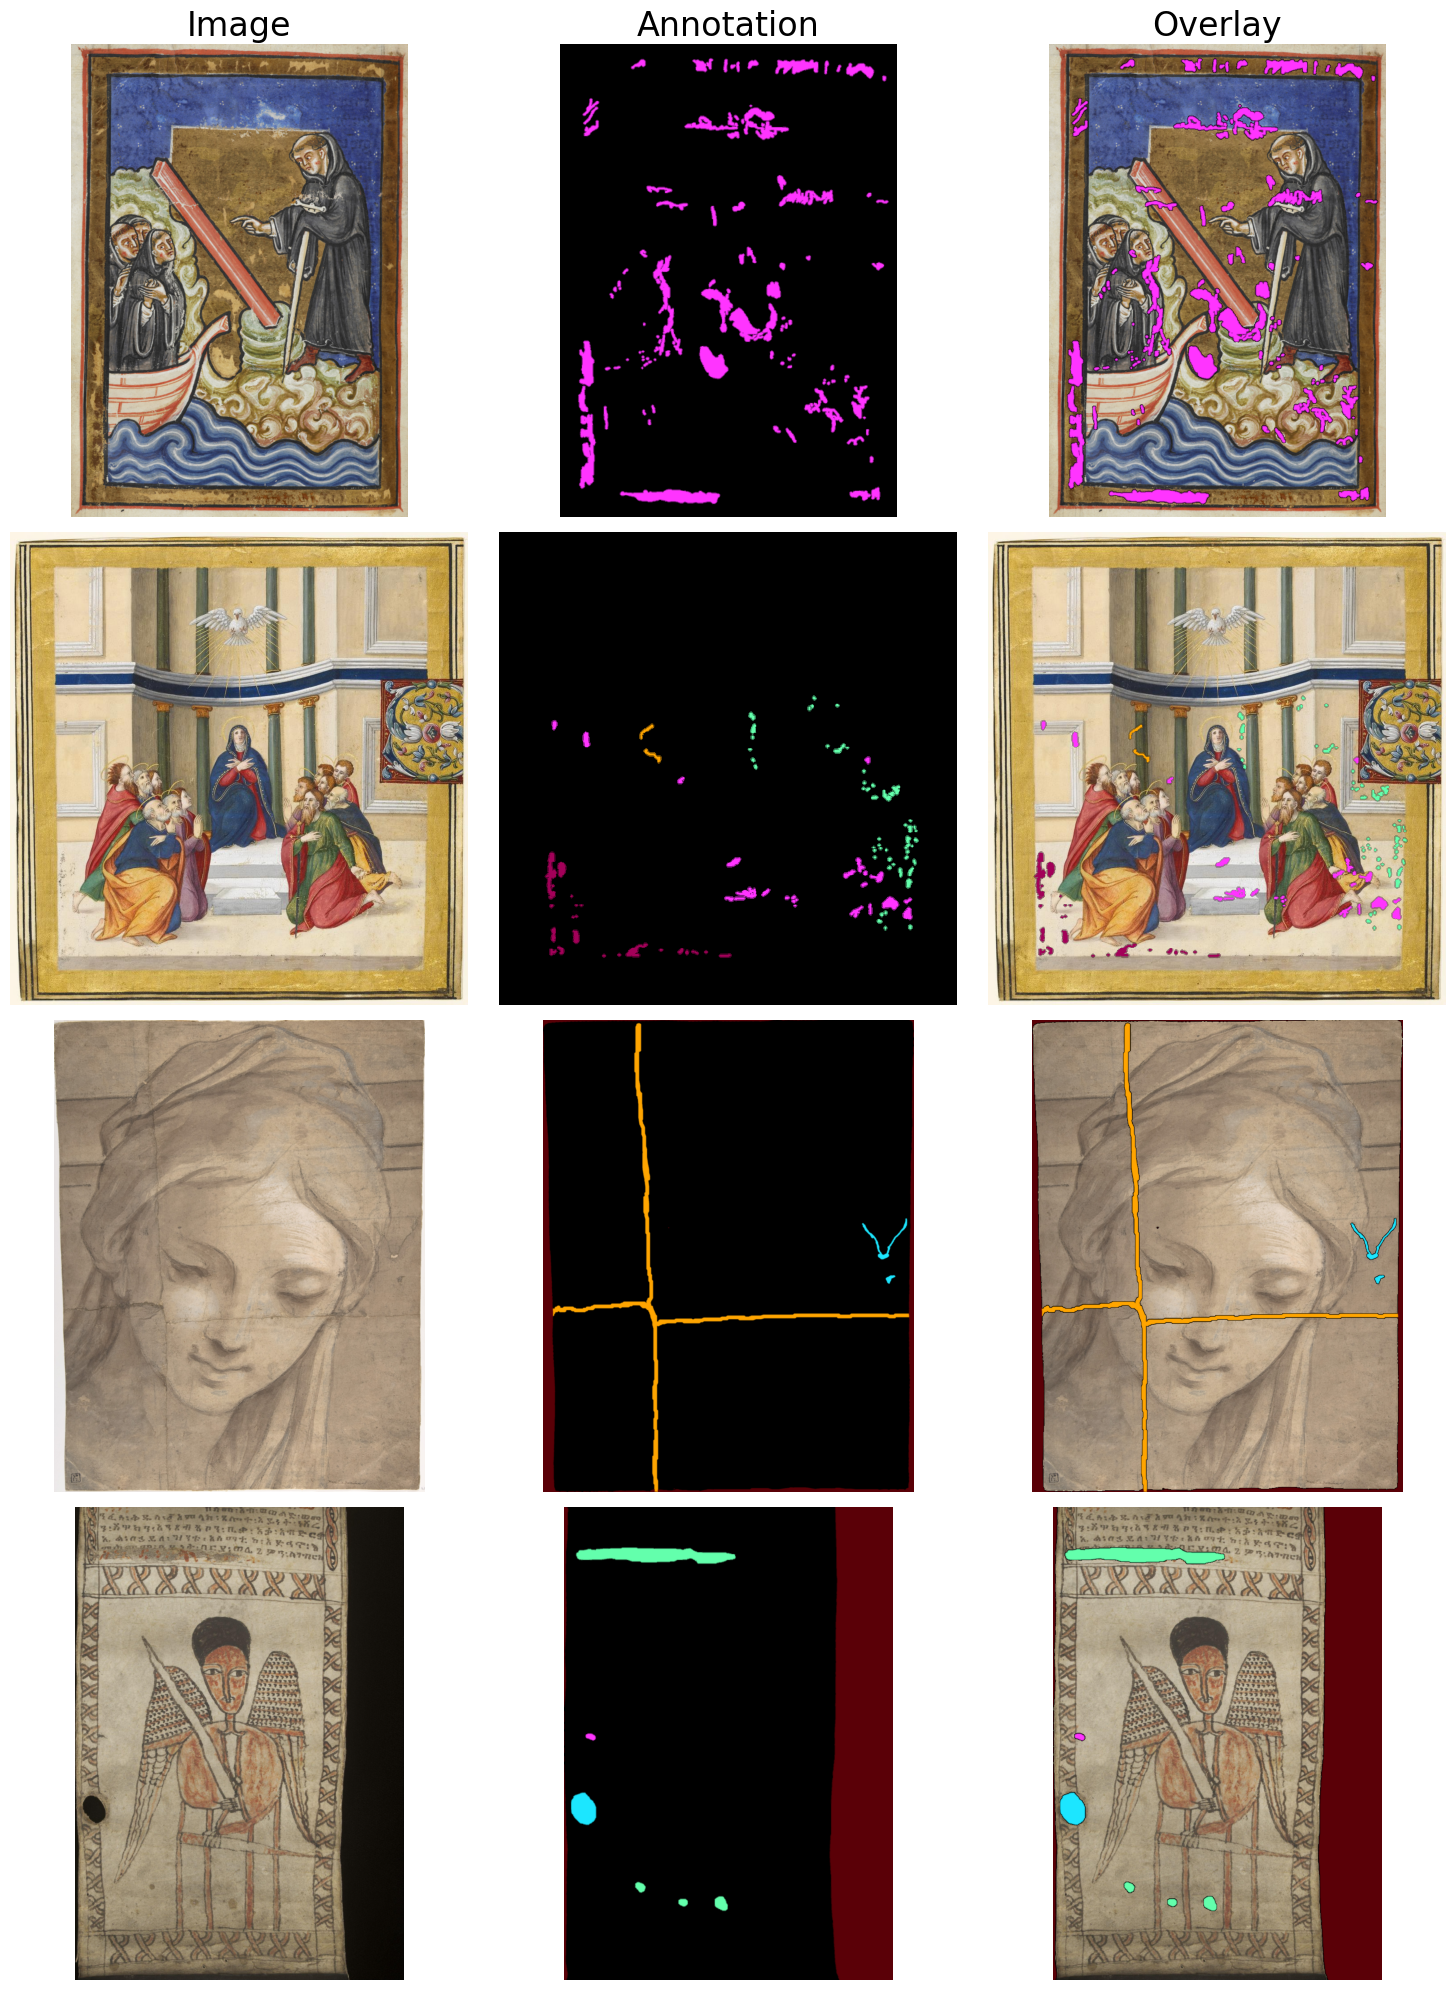

In [ ]:
val_iter = iter(val_loader)
example_batches = [next(val_iter) for _ in range(4)]

# Initialize empty lists to collect different parts of each batch
example_images = []
example_annotations = []
example_annotation_rgbs = []
example_materials = []
example_contents = []

# Populate the lists with the data from the 4 batches
for batch in example_batches:
    example_images.append(batch['image'].squeeze())
    example_annotations.append(batch['annotation'].squeeze())
    example_annotation_rgbs.append(batch['annotation_rgb'].squeeze())
    example_materials.append(batch['material'][0])
    example_contents.append(batch['content'][0])

# Number of examples to visualize
N = min(4, len(example_images))

fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
    ax.set_title(col, fontsize=24)

for i in range(N):
    example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
    example_annotation = example_annotations[i].numpy()
    example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
    example_material = example_materials[i]
    example_content = example_contents[i]
    # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
    alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
    example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))
    axes[i, 0].imshow(example_image)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(example_annotation_rgb)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(example_image)
    axes[i, 2].imshow(example_annotation_rgba)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Evaluation
For the final evaluation of the model, make sure to test performance on the left out category, `Canvas` to have a fair idea on how well the model generalises.

In [ ]:
test_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Canvas',
                               target_size=512,
                               batch_size=4)

test_module.setup()

test_loader = test_module.val_dataloader()



# 1) Setting up the Model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# I'm using a pretrained ResNet50 model
class FCNResNet50(nn.Module):
    def __init__(self, num_classes=17):
        super(FCNResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet50.children())[:-2])

        self.classifier = nn.Conv2d(2048, num_classes, 1)

        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = self.upsample(x)

        return x



# 2) Training Model from Data

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

def train_model(model, dataloaders, criterion, optimizer, num_epochs=1, device=DEVICE):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in dataloaders['train']:
            inputs = batch['image'].to(device)
            labels = batch['annotation'].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        print(f'Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}')
model = FCNResNet50().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

"""
train_model(model, dataloaders, criterion, optimizer, num_epochs=1, device=DEVICE)
"""


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


Epoch 1/25 Loss: 0.8098
Epoch 2/25 Loss: 0.4465
Epoch 3/25 Loss: 0.4144
Epoch 4/25 Loss: 0.3948


# 3) Saving and Loading the Pre-trained Model



In [ ]:
"""
# Save

from google.colab import drive
drive.mount('/content/gdrive')

torch.save(model.state_dict(), '/content/gdrive/MyDrive/DL/damage_model.pth')

# Load
model.load_state_dict(torch.load('/content/gdrive/MyDrive/DL/damage_model.pth'))
model.to(DEVICE)
"""

# 4) Test Model on Test Data

In [ ]:
def evaluate_model(model, dataloader, criterion, device=DEVICE):
    model.eval()
    model.to(device)
    running_loss = 0.0
    model_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['image'].to(device)
            labels = batch['annotation'].to(device)

            outputs = model(inputs)

            # Dynamically resize labels to match the output dimensions
            output_height, output_width = outputs.shape[2], outputs.shape[3]
            labels_resized = torch.nn.functional.interpolate(labels.float().unsqueeze(1),
                                                             size=(output_height, output_width),
                                                             mode='nearest').long().squeeze(1)

            loss = criterion(outputs, labels_resized)
            running_loss += loss.item() * inputs.size(0)

            model_predictions.extend(outputs.argmax(dim=1).cpu().numpy())

    final_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {final_loss:.4f}')
    return model_predictions

model_predictions = evaluate_model(model, test_loader, criterion, DEVICE)


# 5) Using Validation Set for Hyperparameter Tuning


In [ ]:
learning_rates = [1e-3, 5e-4, 1e-4]
batch_sizes = [4, 8, 16]
num_epochs_list = [1, 2, 3]
weight_decays = [1e-4, 1e-5]

best_loss = float('inf')
best_hyperparameters = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            for weight_decay in weight_decays:
                model = FCNResNet50().to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                criterion = nn.CrossEntropyLoss()

                train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, device=DEVICE)

                test_loss = evaluate_model(model, val_loader, criterion, DEVICE)

                if test_loss < best_loss:
                    best_loss = test_loss
                    best_hyperparameters = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs, 'weight_decay': weight_decay}

print("Best hyperparameters:", best_hyperparameters)


# 6) Analyze and Display the Results and Accuracy

In [ ]:
def calculate_iou(prediction, target):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice_coefficient(prediction, target):
    intersection = np.logical_and(target, prediction)
    dice_coefficient = 2 * np.sum(intersection) / (np.sum(target) + np.sum(prediction))
    return dice_coefficient

def calculate_pixel_accuracy(prediction, target):
    pixel_accuracy = np.sum(prediction == target) / target.size
    return pixel_accuracy

iou_scores = []
dice_coefficients = []
pixel_accuracies = []

for i in range(len(model_predictions)):
    prediction = model_predictions[i]
    target = example_annotations[i].numpy()

    iou_scores.append(calculate_iou(prediction, target))
    dice_coefficients.append(calculate_dice_coefficient(prediction, target))
    pixel_accuracies.append(calculate_pixel_accuracy(prediction, target))

average_iou = np.mean(iou_scores)
average_dice = np.mean(dice_coefficients)
average_accuracy = np.mean(pixel_accuracies)

print(f"Average IoU: {average_iou:.4f}")
print(f"Average Dice Coefficient: {average_dice:.4f}")
print(f"Average Pixel Accuracy: {average_accuracy:.4f}")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


test_iter = iter(test_loader)
example_batches = [next(test_iter) for _ in range(4)]

example_images = []
example_annotations = []
example_annotation_rgbs = []
model_predictions = []

for batch in example_batches:
    example_images.append(batch['image'].squeeze())
    example_annotations.append(batch['annotation'].squeeze())
    example_annotation_rgbs.append(batch['annotation_rgb'].squeeze())
    inputs = batch['image'].to(DEVICE)
    with torch.no_grad():
        outputs = model(inputs)
    model_predictions.append(outputs.argmax(dim=1).squeeze().cpu().numpy())

N = min(4, len(example_images))

fig, axes = plt.subplots(N, 4, figsize=(20, 5 * N))

for ax, col in zip(axes[0], ['Image', 'Annotation', 'Model Prediction', 'Overlay']):
    ax.set_title(col, fontsize=24)

for i in range(N):
    example_image = example_images[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
    example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
    model_prediction = model_predictions[i]

    alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
    example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))

    norm = Normalize(vmin=0, vmax=1)
    model_prediction_normalized = norm(model_prediction)

    axes[i, 0].imshow(example_image)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(example_annotation_rgb)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(model_prediction_normalized, cmap='viridis', vmin=0, vmax=1)  # Adjust colormap
    axes[i, 2].axis('off')

    axes[i, 3].imshow(example_image)
    axes[i, 3].imshow(example_annotation_rgba)
    axes[i, 3].imshow(model_prediction_normalized, cmap='viridis', alpha=0.5, vmin=0, vmax=1)  # Adjust colormap
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


# Submission Report
Student ID: 2554321T

## 1. Description of Design Choices

### Architecture Selection
I implemented a Fully Convolutional Network (FCN) based on ResNet50 for semantic segmentation of damage types. The architecture retains the ResNet50 convolutional layers (removing the final fully connected layers) and adds a 1×1 convolutional classifier to produce pixel-wise class predictions across 17 damage categories.

### Transfer Learning & Fine-tuning
The model leverages transfer learning by initializing with ResNet50 weights pre-trained on ImageNet. This approach was chosen because pre-trained features enable better performance on the unseen "Canvas" category. Training from scratch was more computationally prohibitive given resource constraints, and the model also benefits from ImageNet's diverse visual patterns

### Loss Function and Optimization
- Loss: Cross-entropy loss was selected as it effectively measures dissimilarity between predicted and ground-truth class distributions for multi-class segmentation
- Optimizer: Adam optimizer with learning rate 1e-4 provided stable convergence without excessive hyperparameter tuning
- Batch Size: Limited to 4 due to GPU memory constraints (512×512 input resolution)

### Spatial Resolution Handling
To address spatial fidelity challenges, I implemented upsampling as well as label resizing. For upsampling I added `nn.Upsample(scale_factor=32)` to restore original resolution after feature extraction. The ground-truth masks were resized using nearest-neighbor interpolation to match network output dimensions, preserving discrete class labels

## 2. Hyperparameter Tuning

Limited systematic hyperparameter tuning was conducted due to the computational constraints present. The following were used based on standard practices:
- Learning rate: 1e-4 (common baseline for fine-tuning)
- Batch size: 4 (maximum feasible given GPU memory)
- Epochs: Training was monitored for early stopping based on validation loss
- Optimizer: Adam with default β parameters (0.9, 0.999)

Note: More extensive tuning (learning rate schedules, weight decay, different optimizers) would likely improve performance but was not feasible within project constraints.

## 3. Analysis of Final Results

### Quantitative Results
From the evaluation on the "Canvas" test category (generalization test):
- Average IoU (Intersection over Union): TODO
- Average Dice Coefficient: TODO
- Average Pixel Accuracy: TODO

### Qualitative Assessment
The visualizations reveal:
1. Successful cases: The model identifies large, distinct damage regions (stains, missing parts) reasonably well
2. Challenges:
   - Fine details and boundaries are often blurred
   - Some confusion between visually similar damage types
   - Performance degrades on complex patterns or small damage instances
3. Generalization: The model shows some capability on unseen "Canvas" material but with reduced accuracy compared to trained categories

### Key Observations
- The model demonstrates baseline segmentation capability but requires refinement
- Transfer learning provided useful feature representations but domain adaptation remains incomplete
- Upsampling artifacts are visible in predictions, suggesting resolution preservation needs improvement

## 4. Limitations and Future Work

### Current Limitations
- The dataset exhibits significant class imbalance, which the current cross-entropy loss does not address, potentially biasing predictions toward frequent classes
- The 32× upsampling factor introduces artifacts and reduces boundary accuracy
- Limited augmentation was applied, restricting model robustness
- Restricted hyperparameter tuning and architectural experimentation

### Proposed Improvements
1. Advanced Architectures:
   - Implement U-Net or DeepLabV3+ for better spatial precision
   - Add attention mechanisms or pyramid pooling to capture multi-scale features

2. Loss Function Enhancements:
   - Use weighted cross-entropy or Dice loss to address class imbalance
   - Implement boundary-aware losses to improve segmentation edges

3. Data Strategy:
   - Apply comprehensive augmentation (rotations, flips, elastic deformations, color jitter)
   - Implement class-balanced sampling or oversampling for rare damage types

4. Training Improvements:
   - Use learning rate schedules (cosine annealing, step decay)
   - Apply gradient accumulation to enable larger effective batch sizes
   - Implement test-time augmentation for more stable predictions

5. Evaluation Enhancement:
   - Compute per-class metrics to identify specific weaknesses
   - Analyze confusion matrices between damage categories
   - Implement boundary F1-score for edge accuracy assessment

### Conclusion
This project demonstrates a twist on the expected implementation by utilizing a functional baseline for damage segmentation using transfer learning with ResNet50. This was inspired by prior work done in the field of automizing building damage detection. While performance leaves room for improvement, the implementation validates the feasibility of deep learning for cultural heritage preservation. Future work should focus on architectural refinements and addressing the identified limitations to enhance practical utility.